# Path propagation pre- and post-processing

## License

```
Path propagation pre- and post-processing.
Copyright (C) 2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from pycraf import pathprof, geometry, utils
from pycraf import conversions as cnv

## Introduction

Sometimes, the basic pycraf routines are not sufficient for the task at hand. For example, one may want to change the clutter zone type for each pixel in a map (which is currently not possible with the provided API). This is not very hard to do, as the attenuation-map making is a two-step process: (1) calling [`pycraf.pathprof.height_map_data`](https://bwinkel.github.io/pycraf/latest/api/pycraf.pathprof.height_map_data.html#pycraf.pathprof.height_map_data) to create a helper dictionary with the path geometry details, and (2) doing the actual attenuation calculation with [`pycraf.pathprof.atten_map_fast`](https://bwinkel.github.io/pycraf/latest/api/pycraf.pathprof.atten_map_fast.html#pycraf.pathprof.atten_map_fast). The `height_map_data` routine returns a dictionary with various arrays that can be changed, before feeding into `atten_map_fast`. We will show here, how to do that.

### Predicting UHF/VHV path loss
In fact, the [ITU-R Rec. P.1812-4](https://www.itu.int/rec/R-REC-P.1812-4-201507-I/en) provides a method to calculate the point-to-area propagation loss for frequencies between 30 MHz and 3 GHz. The underlying algorithm is largely compatible with [ITU-R Rec. P.452-16](https://www.itu.int/rec/R-REC-P.452-16-201507-I/en), except for a few details as P.1812:

- does not account for atmospheric dampening,
- LoS calculation neglects multipath/focussing effects,
- allows to include building entry loss,
- includes clutter height, $c_i$, along the full propagation path (by just replacing terrain heights $h_i$ with $g_i=h_i+c_i$),
- provides a propagation loss distribution (variability) for each location.

## Tweaking pycraf

Let's first run `height_map_data` as usual and look what the resulting dictionary contains.

In [3]:
# Use the following, if you already have the SRTMDATA environment variable set,
# but not downloaded any ".hgt" files so far.

# pathprof.SrtmConf.set(download='missing', server='viewpano')

# If you neither have the environment variable set nor ".hgt" files downloaded
# (you can use any target directory, of course):

# pathprof.SrtmConf.set(download='missing', server='viewpano', srtm_dir='.')

In [4]:
lon_tx, lat_tx = 6.668140 * u.deg, 50.821743 * u.deg
map_size_lon, map_size_lat = 0.05 * u.deg, 0.05 * u.deg
map_resolution = 1. * u.arcsec

Lets first plot the terrain, to get an idea of the local environment.

In [5]:
lons, lats, heightmap = pathprof.srtm_height_map(
    lon_tx, lat_tx,
    map_size_lon, map_size_lat,
    map_resolution=map_resolution
    )

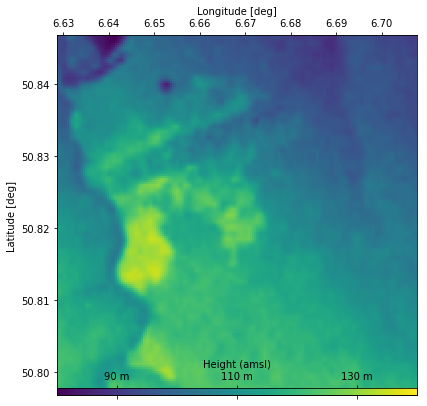

In [6]:
_lons = lons.to(u.deg).value
_lats = lats.to(u.deg).value
_heightmap = heightmap.to(u.m).value

plt.close()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _heightmap,
    origin='lower', interpolation='nearest',
    cmap='viridis', vmin=80, vmax=140,
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
cbar.set_label(r'Height (amsl)', color='k')
cbax.xaxis.set_label_position('top')
for t in cbax.xaxis.get_major_ticks():
    t.tick1On = True
    t.tick2On = True
    t.label1On = False
    t.label2On = True
ctics = np.arange(90, 131, 20)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} m'.format, ctics), color='k')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()

If you compare this with [Google Maps](https://www.google.de/maps/place/50%C2%B049'18.3%22N+6%C2%B040'05.3%22E/@50.8197834,6.6486655,5624m/data=!3m1!1e3!4m6!3m5!1s0x0:0x0!7e2!8m2!3d50.8217426!4d6.6681404) for example, you'll see that the yellowish areas belong to a forest. In fact, as SRTM is based on RADAR it is not surprising that the topographical data from SRTM is not clutter-corrected in many cases. For some areas, you may be lucky and have access to alternative data sets (e.g., from LIDAR missions), which don't have this problem. As long as you provide these other data sources in the `.hgt` format, `pycraf` will be able to work with this.

However, lets assume for the moment, that SRTM is clutter corrected (just for the sake of this presentation). As written in the introduction, we are interested in how to modify the clutter heights later. For this, we first run the `height_map_data` function, as usual. Obviously, we have to use the `UNKNOWN` (aka no clutter) zone for the endpoints:

In [7]:
zone_t, zone_r = pathprof.CLUTTER.UNKNOWN, pathprof.CLUTTER.UNKNOWN
hprof_cache = pathprof.height_map_data(
    lon_tx, lat_tx,
    map_size_lon, map_size_lat,
    map_resolution=map_resolution,
    zone_t=zone_t, zone_r=zone_r,
    )

The returned dictionary `hprof_cache` contains several arrays (which are explained in detail in the documentation). Let's look at a few examples:

### Map coordinates
The lon/lat coordinates are stored as 1D arrays:

In [8]:
hprof_cache['xcoords'][::50], hprof_cache['ycoords'][::50]

(array([ 6.62856646,  6.65055176,  6.67253706,  6.69452236]),
 array([ 50.796743  ,  50.81063189,  50.82452078,  50.83840967]))

If you need the full pixel grid, you can use numpy's `meshgrid`:

In [9]:
lons, lats = np.meshgrid(hprof_cache['xcoords'], hprof_cache['ycoords'])
lons[::50, ::50], lats[::50, ::50]

(array([[ 6.62856646,  6.65055176,  6.67253706,  6.69452236],
        [ 6.62856646,  6.65055176,  6.67253706,  6.69452236],
        [ 6.62856646,  6.65055176,  6.67253706,  6.69452236],
        [ 6.62856646,  6.65055176,  6.67253706,  6.69452236]]),
 array([[ 50.796743  ,  50.796743  ,  50.796743  ,  50.796743  ],
        [ 50.81063189,  50.81063189,  50.81063189,  50.81063189],
        [ 50.82452078,  50.82452078,  50.82452078,  50.82452078],
        [ 50.83840967,  50.83840967,  50.83840967,  50.83840967]]))

This could be fed into a function, which queries the clutter type (or height) for each pixel, for example. As we don't have access to a proper clutter zone database, let's simply add a big spherical structure into the map. Because the height data is not stored as a pixel map, we first need to work out the lon/lat pixel indices, which shall have the structure:

In [10]:
lon_c, lat_c = 6.645, 50.815
clutter_mask = geometry.true_angular_distance(
    lons * u.deg, lats * u.deg, lon_c * u.deg, lat_c * u.deg
    ) < 0.005 * u.deg

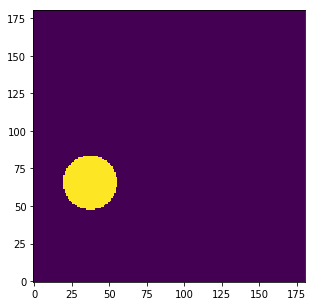

In [11]:
plt.figure(figsize=(5, 5))
plt.imshow(clutter_mask, interpolation='nearest', origin='lower')
plt.show()

We now turn the mask into two lists with the x and y indices:

In [12]:
clutter_x, clutter_y = np.where(clutter_mask)
clutter_x, clutter_y

(array([48, 48, 48, ..., 83, 83, 83]), array([35, 36, 37, ..., 40, 41, 42]))

### Height profiles

The `hprof_cache` stores the height profiles to (virtual) positions along the map edges. In total there are $m_e$ of such height profiles, each with $m_h$ entries. As not all paths have the same length, shorter paths are zero padded:

In [13]:
height_profs = hprof_cache['height_profs'].copy()

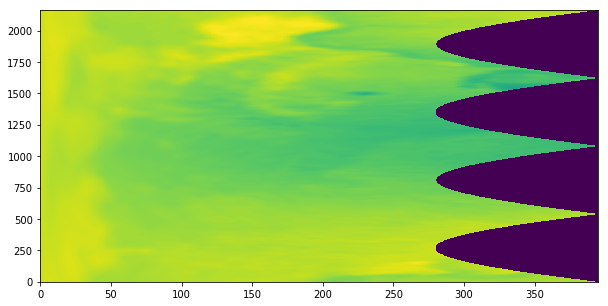

In [14]:
plt.figure(figsize=(10, 5))
plt.imshow(height_profs, interpolation='nearest', origin='lower')
plt.gca().set_aspect('auto')
plt.show()

The difficulty now is to find the positions of our artificial clutter object in this strange representation. The first dimension of the `height_profs` array is the path ID. For each pixel in the (proper) 2D map, the array `path_idx_map` contains the path ID of the path the is closest to the pixel:

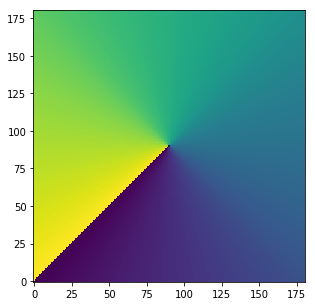

In [15]:
plt.figure(figsize=(5, 5))
plt.imshow(hprof_cache['path_idx_map'], interpolation='nearest', origin='lower')
plt.show()

We can get the correct path IDs, using the pixel indices of the clutter sphere:

In [16]:
clutter_path_ids = hprof_cache['path_idx_map'][clutter_x, clutter_y]

But how to find the position along the second axis in `height_profs`? For this we can use the `dist_end_idx_map` array, which stores exactly this:

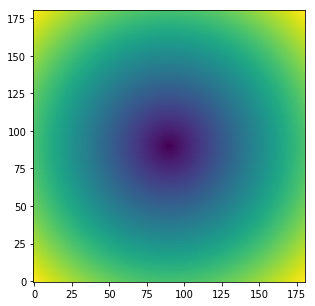

In [17]:
plt.figure(figsize=(5, 5))
plt.imshow(hprof_cache['dist_end_idx_map'], interpolation='nearest', origin='lower')
plt.show()

In [18]:
clutter_path_indexes = hprof_cache['dist_end_idx_map'][clutter_x, clutter_y]

We can now modify the array (adding additional 20 meters to the heights within the circle):

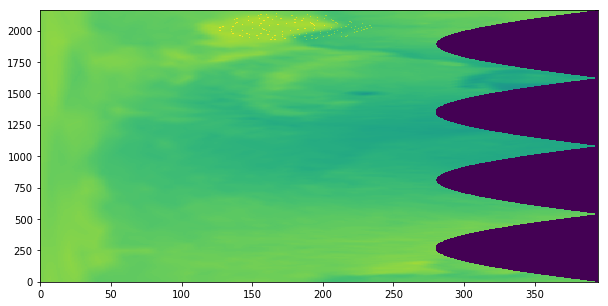

In [19]:
height_profs[clutter_path_ids, clutter_path_indexes] += 20.

plt.figure(figsize=(10, 5))
plt.imshow(height_profs, interpolation='nearest', origin='lower')
plt.gca().set_aspect('auto')
plt.show()

Ups, something went wrong here. The problem with `height_profs` is, that it oversamples the height map for better accuracy.

### Distance vectors and bearings of each profile
So what can we do? One solution would be to calculate the proper lon/lat coordinates for the full `height_profs` array and luckily we can do that by using the bearing and distance vectors:

In [20]:
lons_hires, lats_hires, _ = pathprof.geoid_direct(
    lon_tx, lat_tx,
    hprof_cache['bearing_prof'][:, np.newaxis] * u.deg,
    hprof_cache['dist_prof'][np.newaxis, 1:] * u.km
    )  # this function supports numpy broadcasting

Note that `geoid_direct` can not operate with a zero distance, therefore, we had to skip the first value of `dist_prof`. But we can easily fix this, by inserting the map center coordinates (all paths start at the same position):

In [21]:
lons_hires = np.insert(lons_hires.to(u.deg), 0, lon_tx, axis=1)
lats_hires = np.insert(lats_hires.to(u.deg), 0, lat_tx, axis=1)

OK, another try (with the mask):

In [22]:
clutter_mask_hires = geometry.true_angular_distance(
    lons_hires, lats_hires, lon_c * u.deg, lat_c * u.deg
    ) < 0.005 * u.deg

In [23]:
height_profs = hprof_cache['height_profs'].copy()
height_profs[clutter_mask_hires] += 20

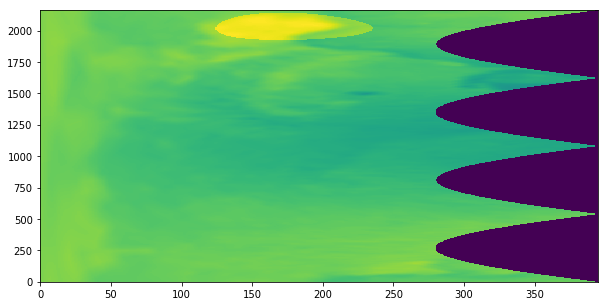

In [24]:
plt.figure(figsize=(10, 5))
plt.imshow(height_profs, interpolation='nearest', origin='lower')
plt.gca().set_aspect('auto')
plt.show()

Assign the modified profiles to the dictionary:

In [25]:
hprof_cache['height_profs'] = height_profs

## Attenuation map
As usual, we can now calculate the attenuation map.

In [26]:
freq = 1. * u.GHz
omega = 0. * u.percent  # fraction of path over sea
temperature = 290. * u.K
pressure = 1013. * u.hPa
timepercent = 2 * u.percent  # see P.452 for explanation
h_tg, h_rg = 20 * u.m, 1.5 * u.m
G_t, G_r = 0 * cnv.dBi, 0 * cnv.dBi

In [27]:
results = pathprof.atten_map_fast(
    freq,
    temperature,
    pressure,
    h_tg, h_rg,
    timepercent,
    hprof_cache,  # dict_like
    )

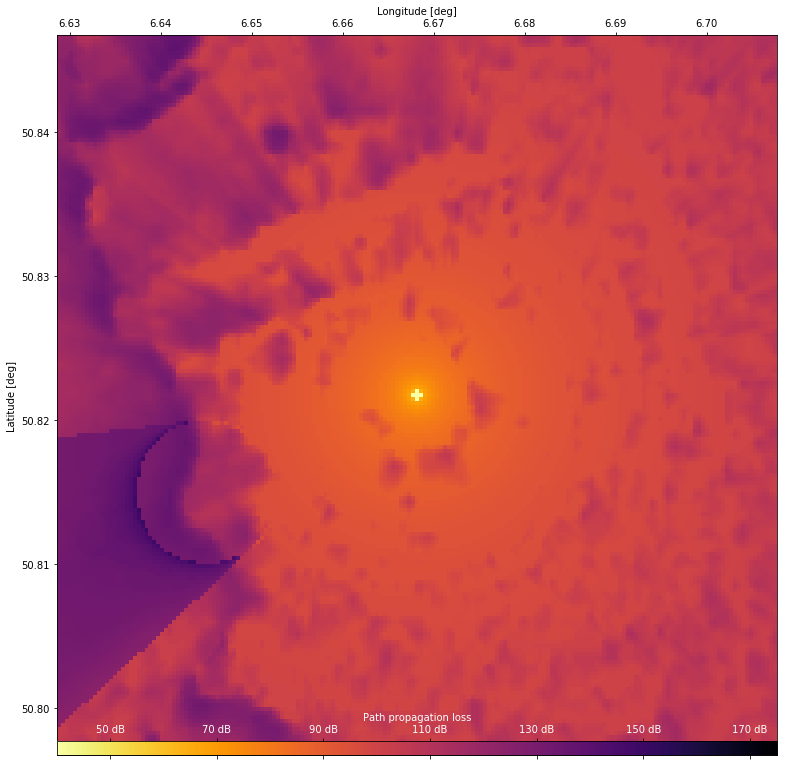

In [28]:
_lons = hprof_cache['xcoords']
_lats = hprof_cache['ycoords']
_total_atten = results['L_b']  # see description of atten_map_fast

vmin, vmax = 40, 175

plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _total_atten.to(cnv.dB).value,
    origin='lower', interpolation='nearest', cmap='inferno_r',
    vmin=vmin, vmax=vmax,
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
cbar.set_label(r'Path propagation loss', color='w')
cbax.xaxis.set_label_position('top')
for t in cbax.xaxis.get_major_ticks():
    t.tick1On = True
    t.tick2On = True
    t.label1On = False
    t.label2On = True
ctics = np.arange(vmin + 10, vmax, 20)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} dB'.format, ctics), color='w')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()

As desired, our artificial clutter object produces a nice shadow in the attenuation map.

## P.1812
### Additional losses due to terminal surroundings
As for P.452, clutter loss at the end points of each path is added to the propagation loss, but P.1812 uses different formulas for this. Therefore, the P.452 calculation with pycraf should be done with `CLUTTER.UNKNOWN` as zones, to avoid the P.452 calculation. Then the following function can be used (for each endpoint):

In [29]:
@utils.ranged_quantity_input(
    h_g=(None, None, u.m),
    R=(None, None, u.m),
    freq=(None, None, u.GHz),
    w_s=(None, None, u.m),
    strip_input_units=True,
    output_unit=cnv.dB
    )
def clutter_p1812(
        h_g, R, clutter_type, freq, w_s=27 * u.m
        ):
    '''
    Calculate the Clutter loss of a propagating radio
    wave according to ITU-R P.1812-4 Section 4.7.

    Parameters
    ----------
    h_g : `~astropy.units.Quantity`
        Height over ground [m]
    R : `~astropy.units.Quantity`
        Representative height of clutter around terminal [m]
    clutter_type : int, array-like
        Type of clutter according to ITU-R P.1812-4 Table 2, [1 or 2]
        Note: Type 1 should be used for (sub-/dense-)urban and trees/forest;
        while type 2 is for water/sea and open/rural terrain.
    freq : `~astropy.units.Quantity`
        Frequency of radiation [GHz]
    w_s : `~astropy.units.Quantity`
        Relates to width of streets for type-1 clutter. Should only be changed
        if specific local information is available (default: 27) [m]

    Returns
    -------
    A_h : `~astropy.units.Quantity`
        Clutter correction to path attenuation [dB]
    '''
    
    def J_edgeknife(nu):
        
        nu = np.atleast_1d(nu)
        J = np.zeros_like(nu)
        mask = nu > -0.78
        J[mask] = (
            6.9 + 20 * np.log10(
                np.sqrt((nu[mask] - 0.1) ** 2 + 1) + nu[mask] - 0.1
                )
            )
        return J

    _h_g, _R, _clutter_type, _freq = np.broadcast_arrays(h_g, R, clutter_type, freq)
    A_h = np.zeros(np.broadcast(h_g, R, clutter_type, freq).shape, dtype=np.float64)
    
    _K_nu = 0.342 * np.sqrt(_freq)
    _K_h2 = 21.8 + 6.2 * np.log10(_freq)
    _h_dif = _R - _h_g
    _theta_clut = np.degrees(np.arctan2(_h_dif, w_s))
    _nu = _K_nu * np.sqrt(_h_dif * _theta_clut)
    
    # type 1: 
    mask1 = (_h_g < _R) & (_clutter_type == 1)
    A_h[mask1] = J_edgeknife(_nu[mask1]) - 6.03
    
    # type 2:
    mask2 = (_h_g < _R) & (_clutter_type == 2)
    A_h[mask2] = -_K_h2[mask2] * np.log10(_h_g[mask2] / _R[mask2])
    
    return A_h 


In [30]:
clutter_types = [[1], [2]]
h_g = np.linspace(1, 12, 12) * u.m
R = 10 * u.m
clutter_p1812(h_g, R, clutter_types, freq)

<Decibel [[ 19.68537545, 18.69852205, 17.57794564, 16.28693603,
            14.77231376, 12.95443265, 10.71164259,  7.86661476,
             4.24238119,  0.        ,  0.        ,  0.        ],
          [ 21.8       , 15.23754609, 11.39875665,  8.67509219,
             6.56245391,  4.83630274,  3.37686273,  2.11263828,
             0.99751329,  0.        ,  0.        ,  0.        ]] dB>

The function supports full broadcasting, i.e., it can be applied to a map of height/R values at once. 

### Location variability
A special feature of P.1812 is the possibility to derive the distribution of loss values for each path that is caused by the spread of ground cover/clutter that is typical for a certain area. The above calculations return the median loss. With the following recipe one could infer the spread around the median. Note, that multi-path effects can also play an important role (see [ITU-R Rec P.1406](https://www.itu.int/rec/R-REC-P.1406/en)), which is neglected here.

In [31]:
@utils.ranged_quantity_input(
    h_g=(0, None, u.m),
    R=(0, None, u.m),
    freq=(None, None, u.GHz),
    strip_input_units=True,
    output_unit=(cnv.dB, cnv.dB)
    )
def location_variability_stddev(
        h_g, R, freq, K_L
        ):
    '''
    Calculate the Clutter loss of a propagating radio
    wave according to ITU-R P.1812-4 Section 4.8.

    Parameters
    ----------
    h_g : `~astropy.units.Quantity`
        Height over ground [m]
    R : `~astropy.units.Quantity`
        Representative height of clutter around terminal [m]
    freq : `~astropy.units.Quantity`
        Frequency of radiation [GHz]
    K_L : float, array-like
        K_L factor, see ITU-R P.1812-4 Section 4.8. Typical values
        would be:
        
        - 5.1 (for receivers with antennas below clutter height
          in urban or suburban environments for mobile systems with
          omnidirectional antennas at car-roof height)
        
        - 4.9 (for receivers with rooftop antennas near the clutter
          height)
          
        - 4.4 (for receivers in rural areas)

    Returns
    -------
    sigma_L : `~astropy.units.Quantity`
        Location variability standard deviation [dB]
    sigma_loc : `~astropy.units.Quantity`
        Location variability standard deviation (height corrected) [dB]
    '''
    
    _h_g, _R, _K_L, _freq = np.broadcast_arrays(h_g, R, K_L, freq)
    
    _sigma_L = _K_L + 1.3 * np.log10(_freq)

    u_h = np.zeros(np.broadcast(h_g, R, K_L, freq).shape, dtype=np.float64)
    mask = (_h_g < _R)
    u_h[mask] = 1
    mask = (_R < _h_g) & (_h_g < _R + 10)
    u_h[mask] = 1 - (_h_g - _R)[mask] / 10
    
    _sigma_loc = _sigma_L * u_h
    
    return _sigma_L, _sigma_loc

In [32]:
@utils.ranged_quantity_input(
    p_L=(1, 99, u.percent),
    sigma_loc=(0, None, cnv.dB),
    strip_input_units=True,
    output_unit=cnv.dB
    )
def location_variability(
        p_L, sigma_loc
        ):
    '''
    Calculate the Clutter loss of a propagating radio
    wave according to ITU-R P.1812-4 Section 4.8.

    Parameters
    ----------
    p_L : `~astropy.units.Quantity`
        Percentage locations [%]
    sigma_loc : `~astropy.units.Quantity`
        Location variability standard deviation (height corrected) [dB]

    Returns
    -------
    delta_L : `~astropy.units.Quantity`
        Delta loss caused by spatial variations [dB]
        Simply add this to the median loss, to get the final loss.
    '''

    from pycraf.pathprof.propagation import _Qinv
    
    return -_Qinv(p_L / 100.) * sigma_loc

In [33]:
p_L = [1, 10, 25, 50, 75, 90, 99] * u.percent
K_L = 5.1
h_g = 5 * u.m
R = 10 * u.m
_sigma_L, sigma_loc = location_variability_stddev(h_g, R, freq, K_L)
location_variability(p_L, sigma_loc)

<Decibel [ -1.18666054e+01, -6.53681697e+00, -3.43836501e+00,
           -6.70293454e-09,  3.43836501e+00,  6.53681697e+00,
            1.18666054e+01] dB>

### Putting everything together
As usual, the individual contributions of the above effects cannot simply be added, because the loss cannot become less than the LoS loss. 

In [34]:
@utils.ranged_quantity_input(
    p_L=(1, 99, u.percent),
    sigma_loc=(0, None, cnv.dB),
    L_b0p=(0, None, cnv.dB),
    L_bc=(0, None, cnv.dB),
    L_be=(0, None, cnv.dB),
    strip_input_units=True,
    output_unit=cnv.dB
    )
def loss_complete(
        p_L, sigma_loc, L_b0p, L_bc, L_be=0 * cnv.dB
        ):
    '''
    Calculate the Clutter loss of a propagating radio
    wave according to ITU-R P.1812-4 Section 4.8.

    Parameters
    ----------
    p_L : `~astropy.units.Quantity`
        Percentage locations [%]
    sigma_loc : `~astropy.units.Quantity`
        Location variability standard deviation [dB]
        For outdoor scenarios, `sigma_loc` should be the height-correct
        value obtained from `location_variability_stddev` function.
        Otherwise, for indoor scenarios one should use
        `sigma_loc = sqrt(sigma_L ** 2 + sigma_be ** 2)`
        with `sigma_be` the building attenuation variation,
        see ITU-R P.1812-4 Section 4.9 [dB]
    L_b0p : `~astropy.units.Quantity`
        Basic transmission loss not exceeded for p% time and 50% locations
        associated with LoS with short term enhancements [dB].
    L_bc : `~astropy.units.Quantity`
        Basic transmission loss not exceeded for p% of time and 50%
        locations, including the effects of terminal clutter losses [dB].
    L_be : `~astropy.units.Quantity`
        For outdoor scenarios, this must be zero, otherwise, for indoor
        this is the building entry loss. See ITU-R P.2040. [dB]

    Returns
    -------
    L_b : `~astropy.units.Quantity`
        Overall path propagation loss [dB].
    
    Notes
    -----
    - The "fast" pycraf functions (`~pycraf.pathprof.atten_map_fast` and
      `~pycraf.pathprof.atten_path_fast`) do not provide the `L_b0p` value,
      unfortunately (this may change in a future release). However, it will
      not introduce a large error, if `L_bfsg` is used instead, as the
      difference between the two is usually far less than a dB.
    - For `L_bc` one should use the `L_b` from pycraf's routines and add
      the clutter using function `clutter_p1812`.
    '''
    
    from pycraf.pathprof.propagation import _Qinv
    
    return np.max([
        L_b0p,
        L_bc + L_be -_Qinv(p_L / 100.) * sigma_loc
        ], axis=0)

In [35]:
L_b0p = results['L_bfsg']  # this is not quite correct!

# assume rural area (for clutter)
R = 10 * u.m
A_tx = clutter_p1812(h_tg, R, 2, freq)
A_rx = clutter_p1812(h_rg, R, 2, freq)
L_bc = results['L_b'] + A_tx + A_rx

Outdoor for location percentage of 98% (want good coverage for most of the time):

In [36]:
p_L = 98 * u.percent
sigma_loc = 4.4 * cnv.dB
L_be=0 * cnv.dB

_total_atten_outdoor = loss_complete(p_L, sigma_loc, L_b0p, L_bc, L_be)

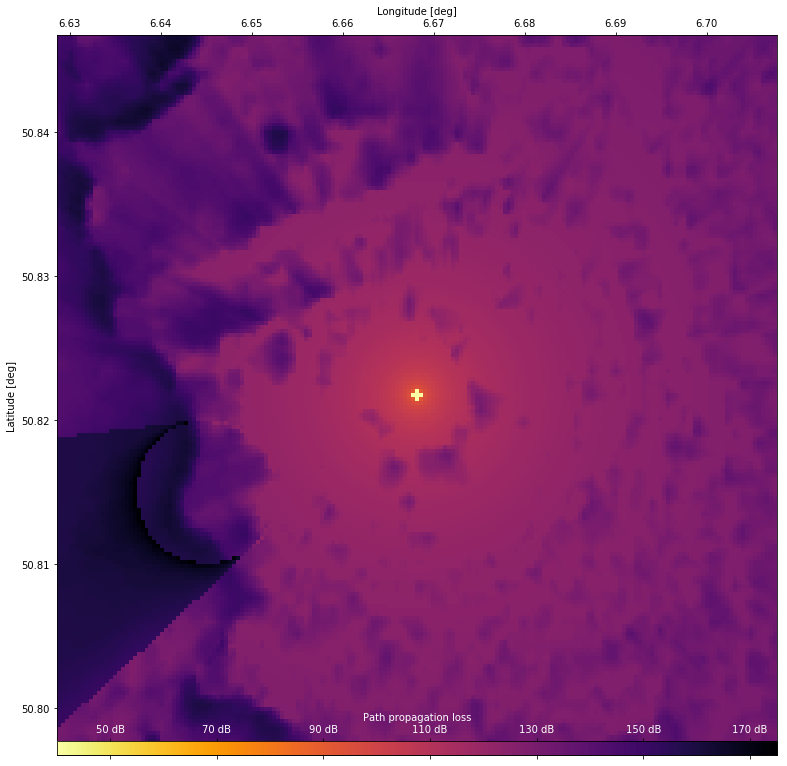

In [37]:
plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _total_atten_outdoor.to(cnv.dB).value,
    origin='lower', interpolation='nearest', cmap='inferno_r',
    vmin=vmin, vmax=vmax,
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
cbar.set_label(r'Path propagation loss', color='w')
cbax.xaxis.set_label_position('top')
for t in cbax.xaxis.get_major_ticks():
    t.tick1On = True
    t.tick2On = True
    t.label1On = False
    t.label2On = True
ctics = np.arange(vmin + 10, vmax, 20)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} dB'.format, ctics), color='w')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()

Indoor for location percentage of 98% (want good coverage for most of the time):

In [38]:
p_L = 98 * u.percent
sigma_loc = np.sqrt(4.4 ** 2 + 3 ** 2) * cnv.dB
L_be = 20 * cnv.dB  # assume 20 dB building entry loss

_total_atten_outdoor = loss_complete(p_L, sigma_loc, L_b0p, L_bc, L_be)

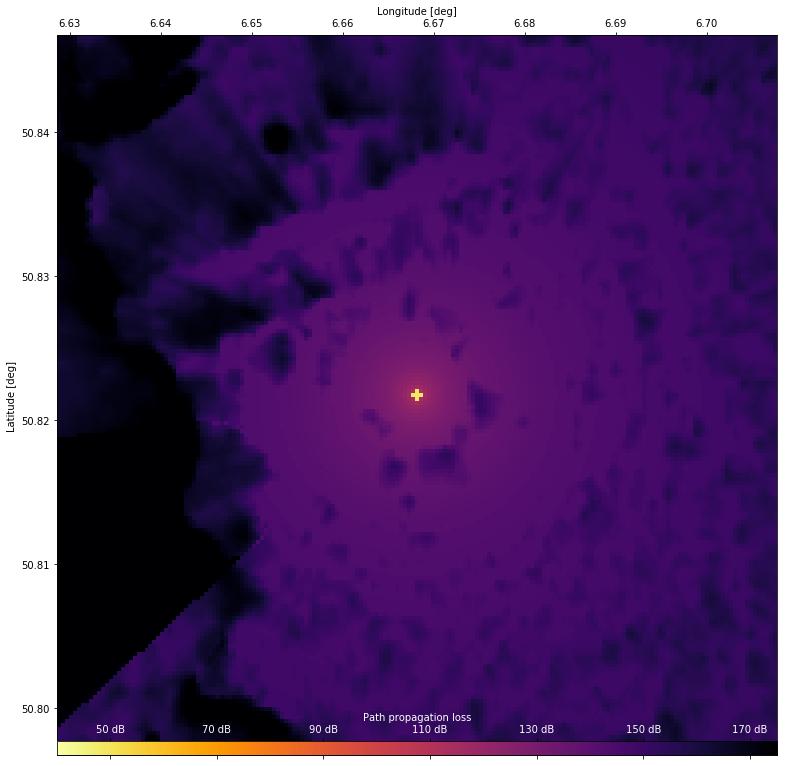

In [39]:
plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _total_atten_outdoor.to(cnv.dB).value,
    origin='lower', interpolation='nearest', cmap='inferno_r',
    vmin=vmin, vmax=vmax,
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
cbar.set_label(r'Path propagation loss', color='w')
cbax.xaxis.set_label_position('top')
for t in cbax.xaxis.get_major_ticks():
    t.tick1On = True
    t.tick2On = True
    t.label1On = False
    t.label2On = True
ctics = np.arange(vmin + 10, vmax, 20)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} dB'.format, ctics), color='w')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()